# Welcome to the K-Means Clustering Notebook!

This notebook explores the K-Means clustering algorithm through two experiments:

**Experiment 1: Step-by-Step K-Means**
- Visualizes the K-Means algorithm's iterations on a simple 2D dataset.
- Tracks the movement of centroids throughout the clustering process.

**Experiment 2: Image Compression with K-Means**
- Demonstrates how K-Means can be used for image compression by reducing the number of colors in an image.
- Shows the effect of using different numbers of clusters (K) on the compressed image.

Feel free to explore the code and visualizations to understand how K-Means works!

In [ ]:
# Libraries stack
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from PIL import Image
import seaborn as sns  # optional, for nicer palettes
sns.set(style="whitegrid")  # optional

# Experiment 1

This experiment visually explores the step-by-step process of the K-Means clustering algorithm on a simple 2D dataset. You will see how the centroids move and how data points are assigned to clusters in each iteration.

## Make data

In [ ]:
# Experiment 1: step-by-step K-Means for visual understanding
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=60, centers=[(90,95),(30,25)], cluster_std=6.0, random_state=42)

## K-Means

In [ ]:
# A simple KMeans runner that returns centroids at each iteration
def kmeans_iterations(X, n_clusters=2, max_iter=6):
    # initialize centroids as random points from X for reproducibility
    rng = np.random.RandomState(0)
    centroids = X[rng.choice(len(X), n_clusters, replace=False)]
    history = [centroids.copy()]
    for it in range(max_iter):
        # assignment
        dists = np.linalg.norm(X[:, None, :] - centroids[None, :, :], axis=2)
        labels = dists.argmin(axis=1)
        # recompute
        new_centroids = np.array([X[labels==k].mean(axis=0) if np.any(labels==k) else centroids[k]
                                  for k in range(n_clusters)])
        history.append(new_centroids.copy())
        # check for small movement -> break
        if np.allclose(new_centroids, centroids):
            break
        centroids = new_centroids
    return history, labels

history, labels_final = kmeans_iterations(X, n_clusters=2, max_iter=10)

## Visualization

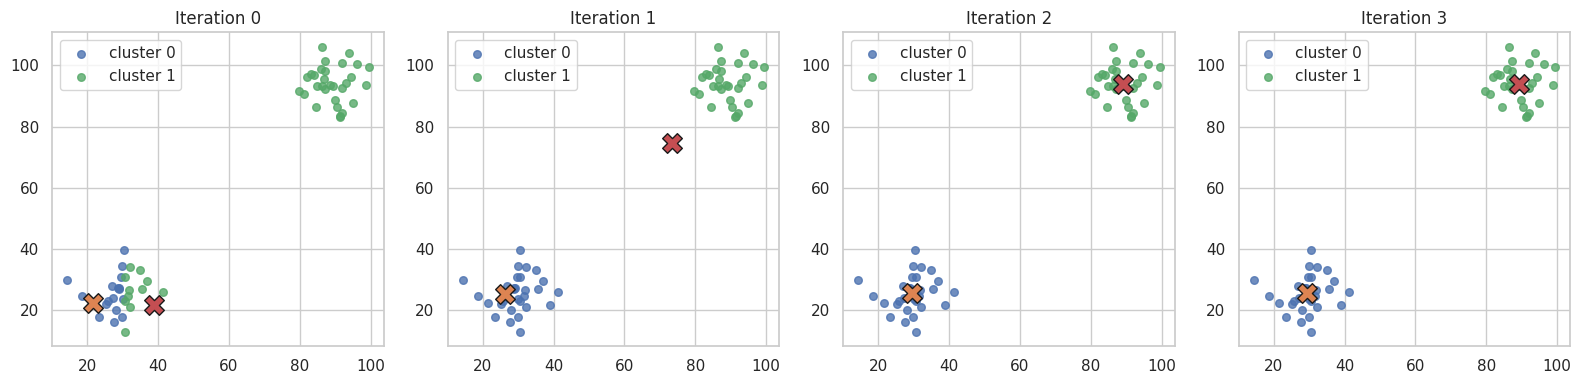

In [ ]:
# Plot iterations
fig, axes = plt.subplots(1, len(history), figsize=(4*len(history), 4))
if len(history) == 1:
    axes = [axes]
for i, cent in enumerate(history):
    ax = axes[i]
    # use final labels for color mapping only for consistent colors OR recompute labels per cent
    dists = np.linalg.norm(X[:, None, :] - cent[None, :, :], axis=2)
    labels = dists.argmin(axis=1)
    for k in range(cent.shape[0]):
        pts = X[labels==k]
        ax.scatter(pts[:,0], pts[:,1], s=30, label=f'cluster {k}', alpha=0.8)
        ax.scatter(cent[k,0], cent[k,1], s=200, marker='X', edgecolor='k')
    ax.set_title(f"Iteration {i}")
    ax.legend()
plt.tight_layout()
plt.show()

## Tracking centroid movements

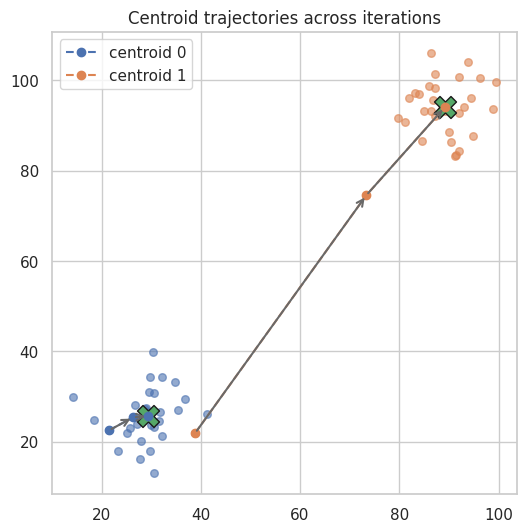

In [ ]:
k = 2
kmeans = KMeans(n_clusters=k, init='random', n_init=1, max_iter=1, random_state=0)
# custom loop to capture centroids each iteration
centroids = None
centroid_history = []

# initialize manually using a random choice (for reproducibility)
rng = np.random.RandomState(0)
centroids = X[rng.choice(len(X), k, replace=False)]
for it in range(10):
    # assignment
    dists = np.linalg.norm(X[:, None, :] - centroids[None, :, :], axis=2)
    labels = dists.argmin(axis=1)
    centroid_history.append(centroids.copy())
    # recompute
    new_centroids = np.array([X[labels==j].mean(axis=0) if np.any(labels==j) else centroids[j] for j in range(k)])
    if np.allclose(new_centroids, centroids):
        break
    centroids = new_centroids

# plotting centroid paths
plt.figure(figsize=(6,6))
colors = sns.color_palette(n_colors=k)
for j in range(k):
    pts = X[(labels==j)]
    plt.scatter(pts[:,0], pts[:,1], s=30, alpha=0.6)
    hist = np.array([h[j] for h in centroid_history])
    plt.plot(hist[:,0], hist[:,1], marker='o', linestyle='--', label=f'centroid {j}')
    # arrows between consecutive centroid positions
    for a,b in zip(hist[:-1], hist[1:]):
        plt.annotate('', xy=b, xytext=a, arrowprops=dict(arrowstyle='->', lw=1.5, color='dimgray'))
plt.scatter(centroids[:,0], centroids[:,1], s=250, marker='X', edgecolor='k')
plt.title("Centroid trajectories across iterations")
plt.legend()
plt.show()

# Experiment 2: Image Compression using K-Means

## Loading and resizing image

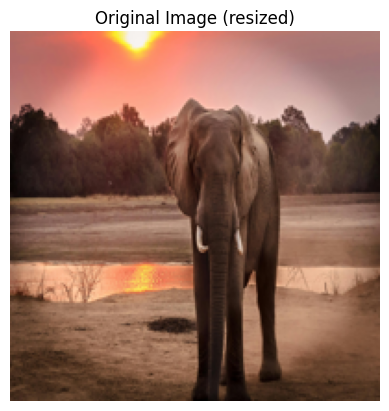

In [ ]:
# Load and preprocess image
img = Image.open("your_image.jpg").convert("RGB")
img_small = img.resize((200, 200))   # resize for speed
arr = np.array(img_small) / 255.0    # normalize to [0,1]
h, w, c = arr.shape
pixels = arr.reshape(-1, 3)          # flatten into (num_pixels, 3)

plt.imshow(img_small)
plt.title("Original Image (resized)")
plt.axis("off")
plt.show()

## Compression

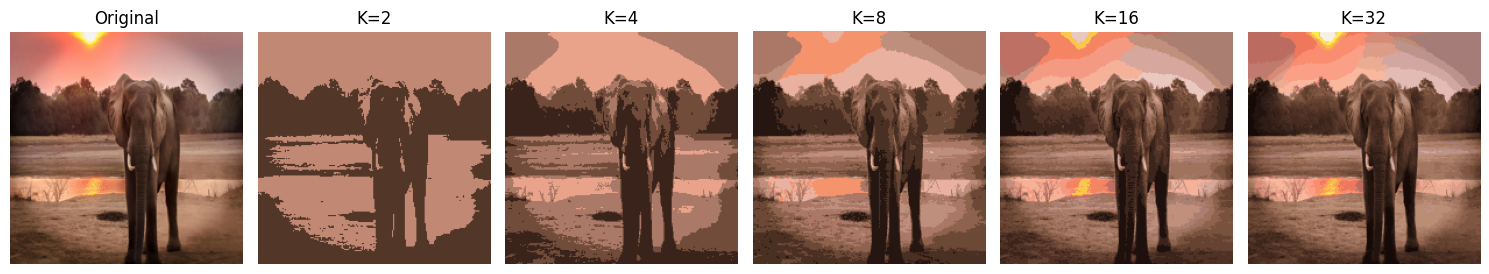

In [ ]:
def compress_image(pixels, h, w, K):
    kmeans = KMeans(n_clusters=K, random_state=42)
    labels = kmeans.fit_predict(pixels)
    new_colors = kmeans.cluster_centers_[labels]
    compressed = (new_colors.reshape(h, w, 3) * 255).astype(np.uint8)
    return Image.fromarray(compressed)

# Try different K values
Ks = [2, 4, 8, 16, 32]

fig, axes = plt.subplots(1, len(Ks)+1, figsize=(15,5))

# original
axes[0].imshow(img_small)
axes[0].set_title("Original")
axes[0].axis("off")

# compressed versions
for i, K in enumerate(Ks, start=1):
    compressed_img = compress_image(pixels, h, w, K)
    axes[i].imshow(compressed_img)
    axes[i].set_title(f"K={K}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

## Observations from Experiment 2

From the image compression experiment using K-Means:

- **Effect of K:** As the number of clusters (K) increases, the compressed image appears more detailed and closer to the original image.
- **Low K (e.g., K=2, K=4):** With a small number of clusters, the image is highly compressed, resulting in a posterized or abstract appearance with large areas of solid color. This is because a limited number of colors are used to represent the entire image.
- **Higher K (e.g., K=16, K=32):** As K increases, more colors are used, leading to a more gradual transition between colors and a less blocky appearance. The details in the image become more discernible.
- **Trade-off:** There is a trade-off between compression ratio (which increases as K decreases) and image quality (which increases as K increases). The choice of K depends on the desired level of compression and the acceptable loss of image quality.
- **Color Quantization:** K-Means effectively performs color quantization by grouping similar colors together into K clusters and representing all colors within a cluster by the cluster centroid's color.